***PART 1: Data Loading and First Look***

In [253]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets as ds
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from scipy import stats

from pandas.core.frame import DataFrame
from sklearn.model_selection import train_test_split

In [254]:
# Q1: Load the dataset into a Pandas DataFrame.
df = pd.read_csv('virus_data.csv', sep=',')
print(df.shape)

(1250, 25)


In [255]:
# Q2: Print the value_counts of the conversations_per_day feature.
df.conversations_per_day.value_counts(dropna=False)

conversations_per_day
3     218
2     204
5     179
4     168
1     108
6     107
7      94
8      54
9      42
10     29
11     16
13      8
12      7
14      6
16      5
15      3
17      1
29      1
Name: count, dtype: int64

In [256]:
# Q4: Split the data randomly into a training set (80% of the data) and a test set (20% of the data)
# our IDs: 206708463, 212201057
train_df, test_df = train_test_split(df, test_size=0.2, random_state=120)

***PART 2: Missing Values***

In [257]:
# Q5: For both the training set and test set, report which fields have missing values and how many missing values there are
train_missing_values = train_df.isnull().sum()
test_missing_values = test_df.isnull().sum()

print("Missing values in training set:")
print(train_missing_values)

print("\nMissing values in test set:")
print(test_missing_values)



Missing values in training set:
patient_id                0
age                       0
sex                       0
weight                    0
blood_type                0
current_location          0
num_of_siblings           0
happiness_score           0
household_income         85
conversations_per_day     0
sugar_levels              0
sport_activity            0
pcr_date                  0
PCR_01                    0
PCR_02                    0
PCR_03                    0
PCR_04                    0
PCR_05                    0
PCR_06                    0
PCR_07                    0
PCR_08                    0
PCR_09                    0
PCR_10                    0
spread                    0
risk                      0
dtype: int64

Missing values in test set:
patient_id                0
age                       0
sex                       0
weight                    0
blood_type                0
current_location          0
num_of_siblings           0
happiness_score           0
ho

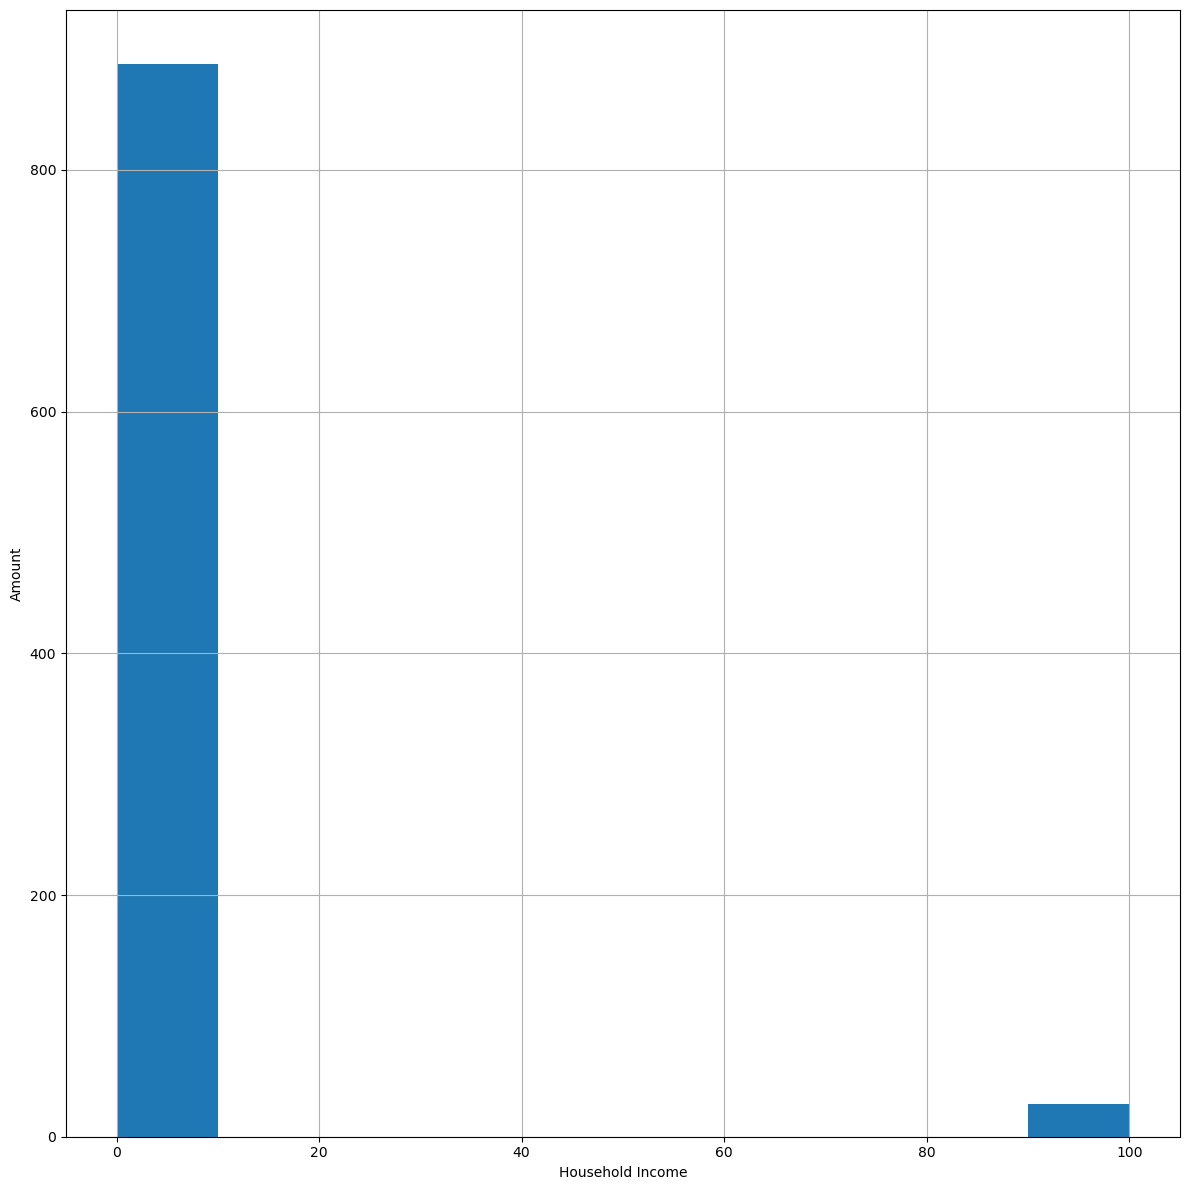

In [258]:
# Q6: Plot a  histogram  for  each field  where  you found missing  values  in  the  training  set.
train_df.household_income.hist(figsize=(12, 12))
plt.xlabel("Household Income")
plt.ylabel("Amount")
plt.tight_layout()
plt.show()

In [259]:
# Q7: For each field where you found missing values, calculate the median and the mean in the training set, and report it.
missing_fields = train_missing_values[train_missing_values > 0].index
train_df[missing_fields].agg(['median', 'mean'])

household_income
median          0.700000
mean            3.641311

In [260]:
# Q8: Fill in the missing values in the training set with the median value of the corresponding field.
train_df.household_income.fillna(train_df.household_income.median(), inplace=True)


****Part 3: Warming up with k-Nearest Neighbors****

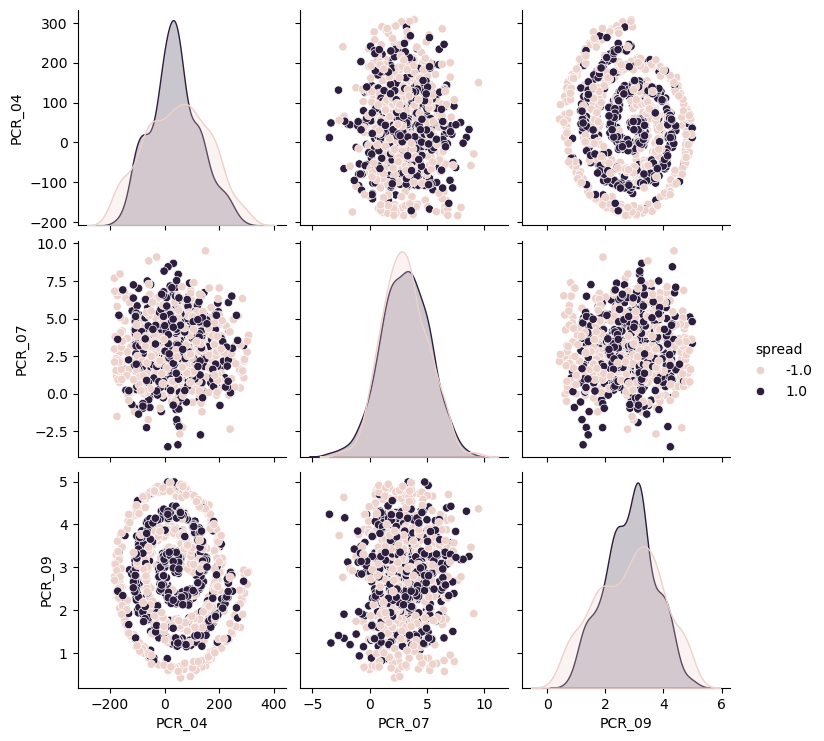

In [261]:
# Task B: {PCR_04 , PCR_07 , PCR_09}  For  each  possible  pair  from  this  set,  create  a  seaborn.pairplot  of  the  two aforementioned PCR features. Use the hue parameter to color the different (train) data points according to their spread
pair_features = ['PCR_04', 'PCR_07', 'PCR_09']
sns.pairplot(train_df, vars=pair_features, hue='spread')
plt.show()

In [262]:
#Task C: implement Knn
from sklearn.base import BaseEstimator,ClassifierMixin
class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors:int = 3):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # TODO: complete
        self.X_train = X.copy()
        self.y_train = y.copy()
        return self

    def predict(self, X):
        
        # Note: You can use self.n_neighbors here
        # K = n_neighbors, m = number of test samples, d = number of features

        #distances = distance.cdist(X, self.X_train, metric='euclidean')
        #nearest_indices = np.argpartition(distances, self.n_neighbors) 
        #nearest_labels = self.y_train.values[nearest_indices]
        #print(nearest_labels)
        #predictions = np.sign(np.sum(nearest_labels, axis=1))

        distances = distance.cdist(X, self.X_train) # time complexity O(m * d)
        minDictancesLabels = self.y_train.to_numpy()[distances.argpartition(self.n_neighbors)] # time complexity O(m)
        predictions = np.sign(np.sum(minDictancesLabels[:, :self.n_neighbors], axis=1)) # time complexity O(m)
        return np.asarray(predictions)


In [263]:
######################
def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()
   
######################

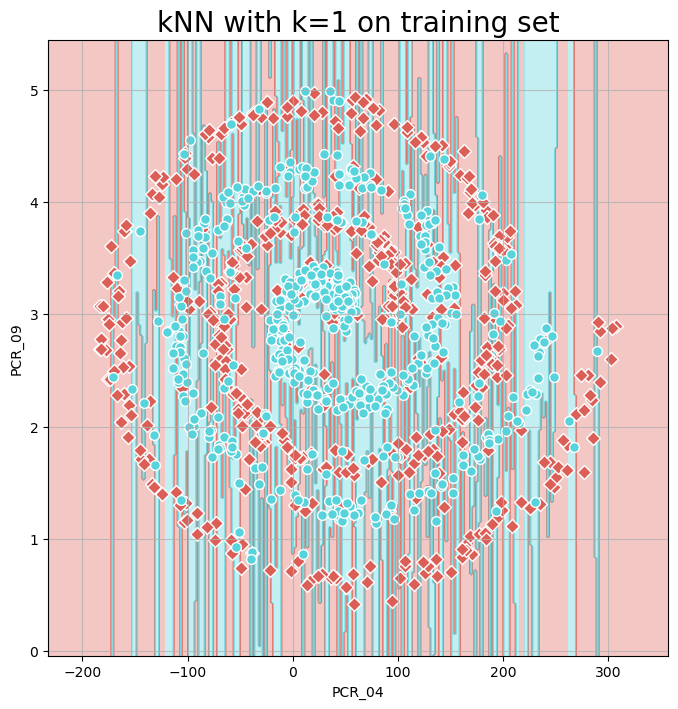

KNN accuracy on train set: 100.0%


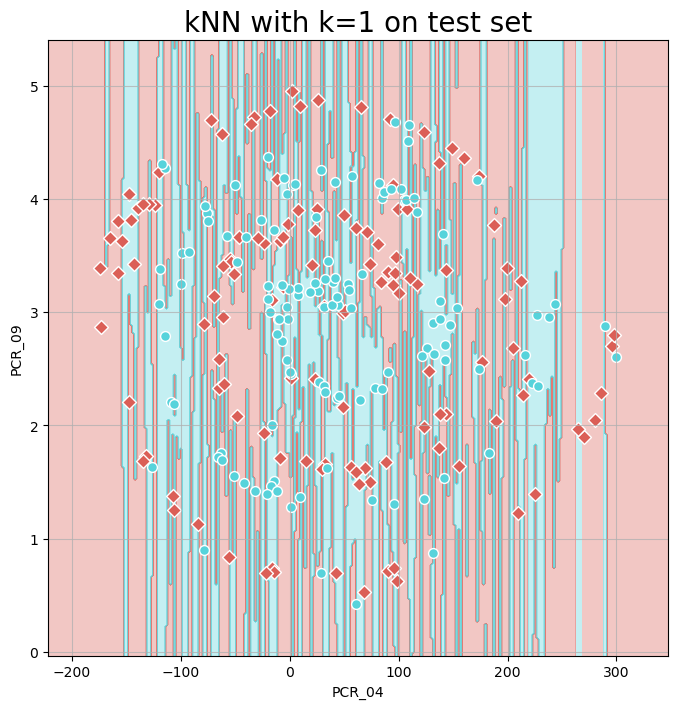

KNN accuracy on test set: 59.599999999999994%


In [264]:
# Task D: Create a temporary DataFrame by taking only the two features you chose on (Q8)  
# from the training set. Train a 1-NN model (with k=1) on this subset to fit the spread 
# label. Use the provided visualize_clf function to visualize the decision regions of the model
knn = kNN(n_neighbors=1)

temp_df = train_df[['PCR_04', 'PCR_09', 'spread']]
X = temp_df[['PCR_04', 'PCR_09']]
y = temp_df['spread']

knn.fit(X, y)

visualize_clf(knn, X, y, "kNN with k=1 on training set","PCR_04","PCR_09") # accuracy instead of score
print("KNN accuracy on train set: " + (knn.score(X,y) * 100.0).__str__() + "%")

temp_df = test_df[['PCR_04', 'PCR_09', 'spread']]
X_test = temp_df[['PCR_04', 'PCR_09']]
y_test = temp_df['spread']

visualize_clf(knn, X_test, y_test, "kNN with k=1 on test set","PCR_04","PCR_09") # accuracy instead of score
print("KNN accuracy on test set: " + (knn.score(X_test, y_test) * 100.0).__str__() + "%")


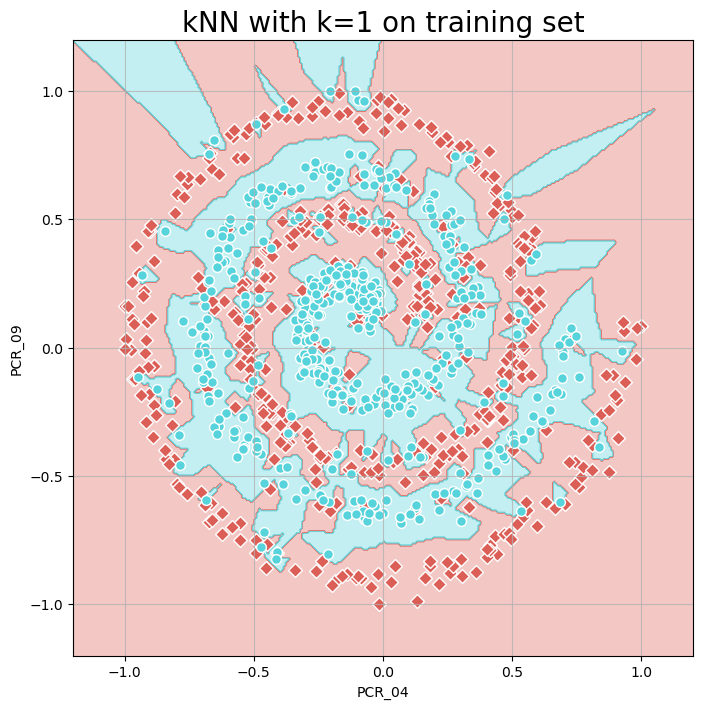

KNN (after min-max scaling) accuracy on training set: 100.0%


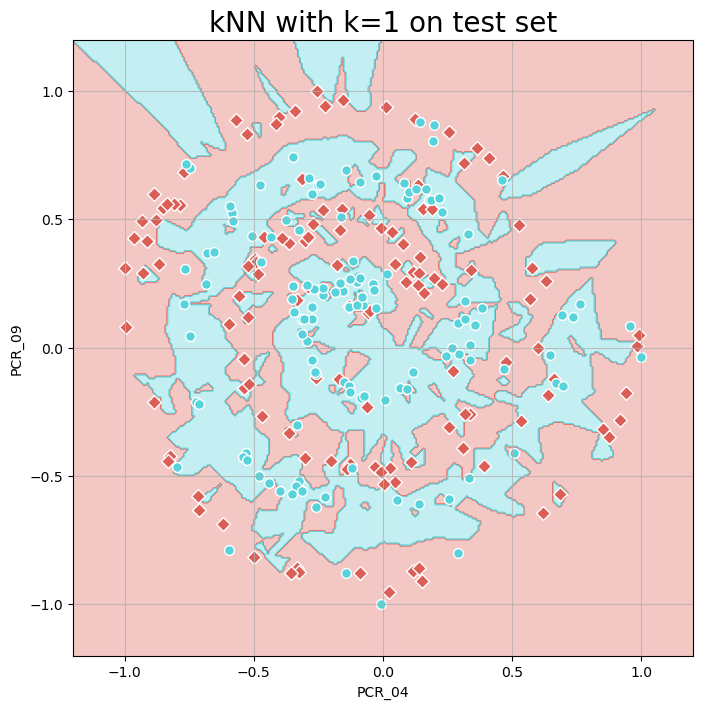

KNN (after min-max scaling) accuracy on test set: 74.8%


In [265]:
# Q11: Use min-max scaling (between [−1,1]) to normalize the two features in the temporary 
# DataFrame  you  created  before,  and  train  a  new  kNN  model  (𝑘=1)  on  the 
# normalized dataset

Scaler=MinMaxScaler(feature_range=(-1,1))
X_after_fit=Scaler.fit_transform(X)

knn_min_max = kNN(1)
knn_min_max.fit(X_after_fit, y)
visualize_clf(knn_min_max, X_after_fit, y, "kNN with k=1 on training set","PCR_04","PCR_09") # accuracy instead of score
print("KNN (after min-max scaling) accuracy on training set: " + (knn_min_max.score(X_after_fit, y) * 100.0).__str__() + "%")

X_test_after_fit = Scaler.fit_transform(X_test)
visualize_clf(knn_min_max, X_test_after_fit, y_test, "kNN with k=1 on test set", "PCR_04", "PCR_09") # accuracy instead of score
print("KNN (after min-max scaling) accuracy on test set: " + (knn_min_max.score(X_test_after_fit, y_test) * 100.0).__str__() + "%")


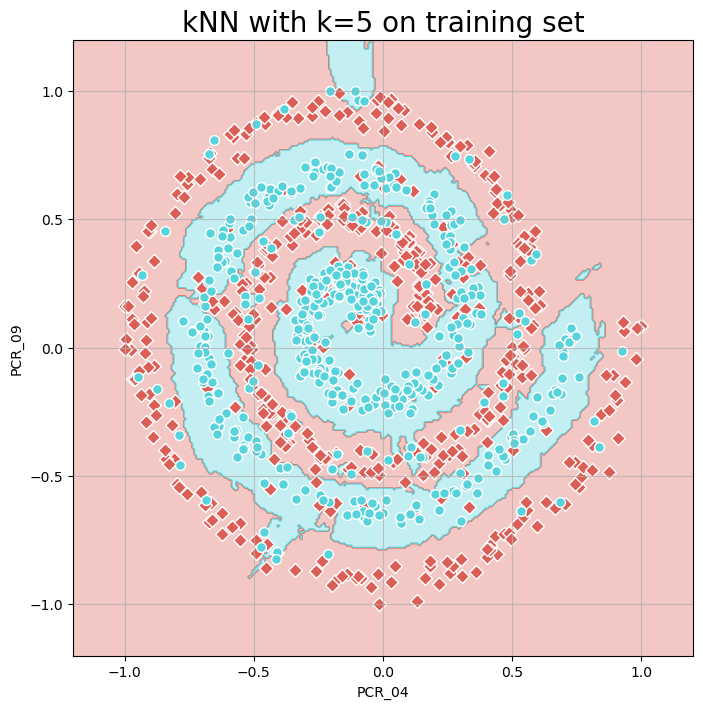

KNN (after min-max scaling) accuracy on training set: 84.6%


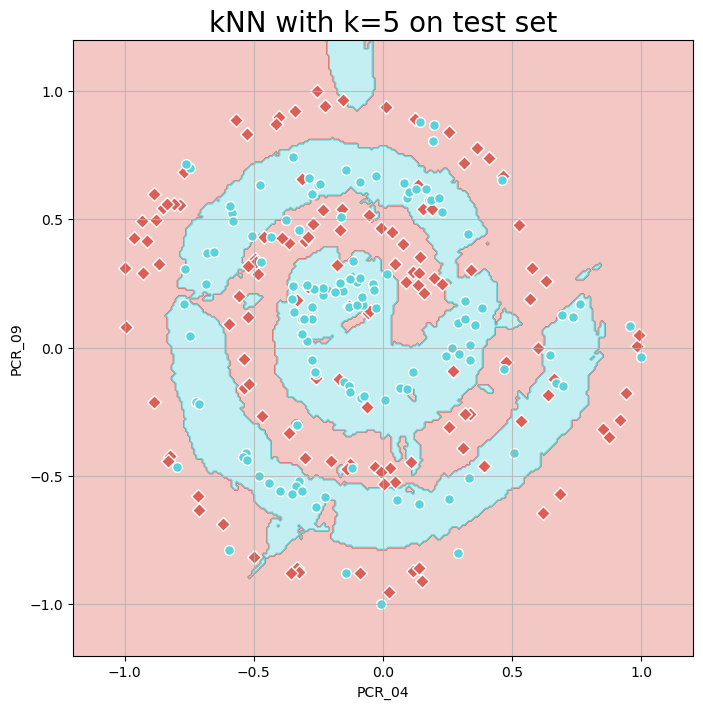

KNN (after min-max scaling) accuracy on test set: 83.2%


In [266]:
# Q12: Using  the  normalized  dataset,  train  another  kNN  model  with  𝑘 = 5.  Compute  the 
# training and test accuracy and draw the decision regions of this model.
knn_min_max_5 = kNN(5)
knn_min_max_5.fit(X_after_fit, y)
visualize_clf(knn_min_max_5, X_after_fit, y, "kNN with k=5 on training set","PCR_04","PCR_09") # accuracy instead of score
print("KNN (after min-max scaling) accuracy on training set: " + (knn_min_max_5.score(X_after_fit, y) * 100.0).__str__() + "%")

visualize_clf(knn_min_max_5, X_test_after_fit, y_test, "kNN with k=5 on test set", "PCR_04", "PCR_09") # accuracy instead of score
print("KNN (after min-max scaling) accuracy on test set: " + (knn_min_max_5.score(X_test_after_fit, y_test) * 100.0).__str__() + "%")


In [267]:
# Task E: According to the suggested  groups, create a new  Boolean feature called 
# SpecialProperty  in  your  DataFrame,  indicating  whether  the  specific  data  point 
# has a blood type in {O+, B+} or not. Then, remove the original blood_type feature 
# from the DataFrame
train_df['SpecialProperty'] = train_df['blood_type'].isin(['O+', 'B+'])
train_df.drop(columns=['blood_type'], inplace=True)

test_df['SpecialProperty'] = test_df['blood_type'].isin(['O+', 'B+'])
test_df.drop(columns=['blood_type'], inplace=True)


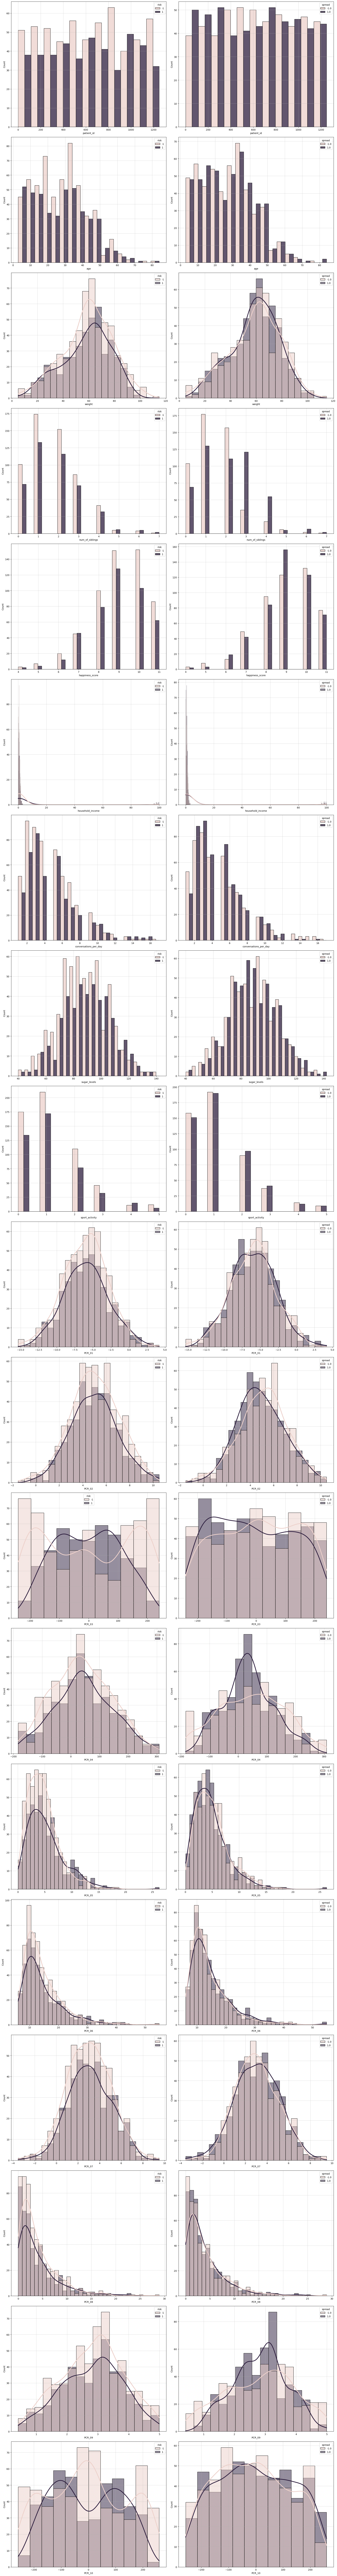

In [268]:
# Q14 + Q15: For every numerical feature (including extracted ones), plot two histograms, one for each 
# target variable (risk and spread), using hue to split by the target variable's value (e.g., 
# high/low spread value). For continuous/ordinal features you should use the kde keyword to 
# draw the estimated distribution curve 

COL_NAME = train_df.select_dtypes(include=[np.number]).columns.drop(['risk', 'spread'])
COLS, ROWS = (2, len(COL_NAME))
plt.figure(figsize=(10 * COLS, 8 * ROWS))
for row in range(ROWS):
  column = COL_NAME[row]
  for j, cls in enumerate(["risk", "spread"]):
    plt.subplot(ROWS,COLS, row * COLS + 1 + j)
    isContinuous = "float" in train_df[column].dtype.name
    sns.histplot(data=train_df, x=column, hue=cls, line_kws={"linewidth": 3},
    kde=isContinuous, multiple="layer" if isContinuous else "dodge")
    plt.grid(alpha=0.5)
plt.tight_layout()

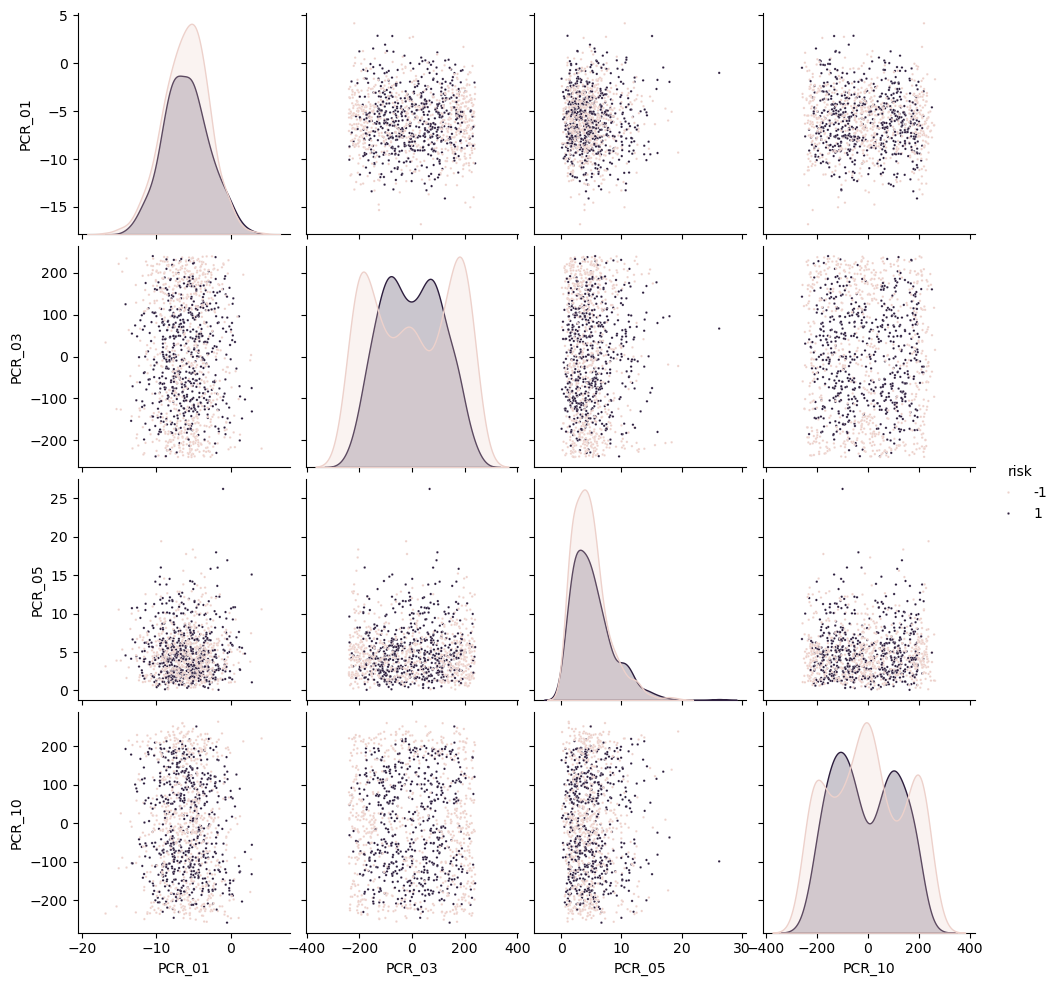

In [269]:
# Q16: Split the (training) data based on the binary SpecialProperty feature created in 
# (Task E). For each split, perform a bivariate analysis for the PCR features in the set, 
# in relation to the risk.

# Split the data based on the SpecialProperty feature
special_property_df = train_df[train_df['SpecialProperty'] == True]
non_special_property_df = train_df[train_df['SpecialProperty'] == False]

set_of_PCR = df.filter(items=['PCR_01', 'PCR_03', 'PCR_05', 'PCR_10'])
sns.pairplot(df[set_of_PCR.columns.tolist() + ["risk"]],plot_kws={"s": 3}, hue="risk")

Text(0.5, 0.98, 'PCR_03 vs PCR_10 by risk (Full Data)')

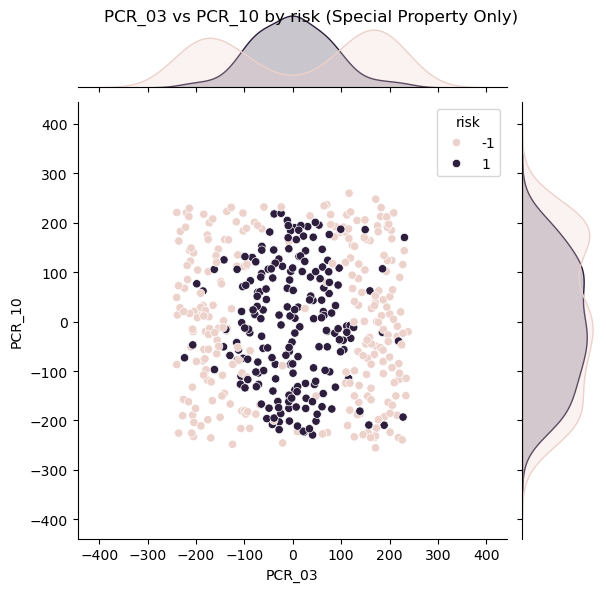

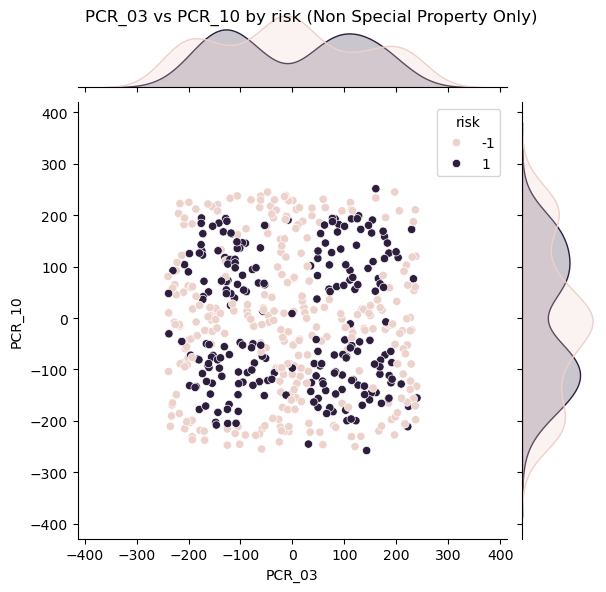

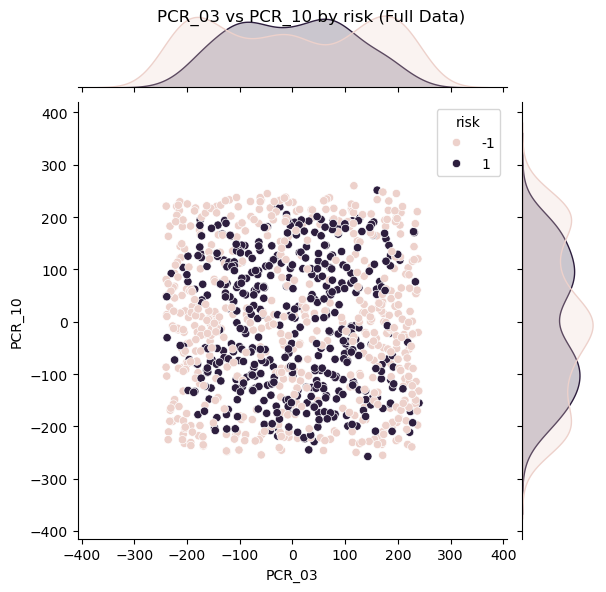

In [270]:
# Q17: For the pair of PCR features you chose in (Q16), create three jointplots,
# all conditioned on the risk variable. The first jointplot should 
# include only the data in the first blood group you created in (Task E), {O+, B+}. The 
# second jointplot should include only the data in the other blood group. The third 
# jointplot should be for the full data, without partitioning to blood groups.


sns.jointplot(data=special_property_df, x='PCR_03', y='PCR_10', hue='risk').figure.suptitle("PCR_03 vs PCR_10 by risk (Special Property Only)")
sns.jointplot(data=non_special_property_df, x='PCR_03', y='PCR_10', hue='risk').figure.suptitle("PCR_03 vs PCR_10 by risk (Non Special Property Only)")
sns.jointplot(data=train_df, x='PCR_03', y='PCR_10', hue='risk').figure.suptitle("PCR_03 vs PCR_10 by risk (Full Data)")

In [271]:
######################################
def plot3d(df, colX, colY, colZ, title, hue=None, s=1):
  %matplotlib inline

  fig = plt.figure(figsize=(20, 4))
  axes = [fig.add_subplot(1, 4, 1, projection='3d'),
          fig.add_subplot(1, 4, 2, projection='3d'),
          fig.add_subplot(1, 4, 3, projection='3d'),
          fig.add_subplot(1, 4, 4, projection='3d')]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if hue is None:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=s)
    else:
      idx = df[hue] == True
      df1 = df[idx]
      df2 = df[~idx]

      ax.scatter3D(df1[colX], df1[colY], df1[colZ], color=palette[0], s=s)
      ax.scatter3D(df2[colX], df2[colY], df2[colZ], color=palette[1], s=s)

    if i == 3 or i == 1:
      ax.set_xlabel(colX, labelpad=20)
      ax.set_ylabel(colY, labelpad=20)
    else:
      ax.xaxis.set_ticklabels([])
      ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i+15)

  axes[1].set_zlabel("\n" + colZ, labelpad=1)

  plt.suptitle(title)
  plt.subplots_adjust(wspace=0.1, top=0.99)
  plt.show()
######################################

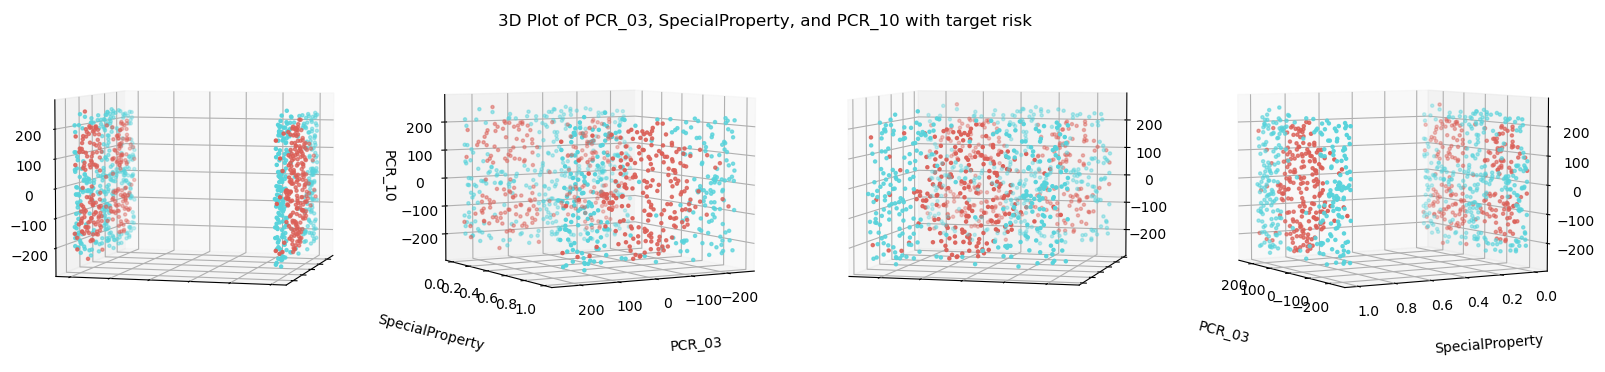

In [272]:
plot3d(train_df, "PCR_03", "SpecialProperty", "PCR_10", title="3D Plot of PCR_03, SpecialProperty, and PCR_10 with target risk", hue="risk", s=5)

***Part 5: More Data Normalization***

In [273]:

# Task E: Use the univariate analysis above to choose an appropriate normalization method 
# (see Part 2) for every PCR feature in your DataFrame. Accordingly, apply sklearn’s 
# StandardScaler and MinMaxScaler to those features. 
# In (Q23) you are asked to specify the normalization method you chose for each feature. 
# Hint: Think about (Q13) when deciding which scaler to use for each feature.


scaler_standard = StandardScaler()
train_df[['PCR_05', 'PCR_01', 'PCR_02', 'PCR_07', 'PCR_06', 'PCR_08']] = scaler_standard.fit_transform(train_df[['PCR_05', 'PCR_01', 'PCR_02', 'PCR_07', 'PCR_06', 'PCR_08']])

scaler_minmax = MinMaxScaler(feature_range=(-1, 1))
train_df[['PCR_03', 'PCR_04', 'PCR_09', 'PCR_10']] = scaler_minmax.fit_transform(train_df[['PCR_03', 'PCR_04', 'PCR_09', 'PCR_10']])


In [274]:
def prepare_data(training_data, new_data):
    copied_training_data = training_data.copy()
    copied_new_data = new_data.copy()

    copied_new_data.household_income.fillna(copied_training_data.household_income.median(), inplace=True)

    copied_training_data['SpecialProperty'] = copied_training_data['blood_type'].isin(['O+', 'B+'])
    copied_training_data.drop(columns=['blood_type'], inplace=True)

    copied_new_data['SpecialProperty'] = copied_new_data['blood_type'].isin(['O+', 'B+'])
    copied_new_data.drop(columns=['blood_type'], inplace=True)

    scaler_standard = StandardScaler()
    scaler_standard.fit(copied_training_data[['PCR_01', 'PCR_02', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08']])
    copied_new_data[['PCR_01', 'PCR_02', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08']] = scaler_standard.transform(copied_new_data[['PCR_01', 'PCR_02', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08']])

    scaler_minmax = MinMaxScaler(feature_range=(-1, 1))
    scaler_minmax.fit(copied_training_data[['PCR_03', 'PCR_04', 'PCR_09', 'PCR_10']])
    copied_new_data[['PCR_03', 'PCR_04', 'PCR_09', 'PCR_10']] = scaler_minmax.transform(copied_new_data[['PCR_03', 'PCR_04', 'PCR_09', 'PCR_10']])

    return copied_new_data

In [275]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=120) 
train_df_prepared = prepare_data(train_df, train_df) 
test_df_prepared = prepare_data(train_df, test_df)

train_df_prepared.to_csv('train_df_prepared.csv', index=False)
test_df_prepared.to_csv('test_df_prepared.csv', index=False)